# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__. 

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [2]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [3]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [4]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros
    
    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

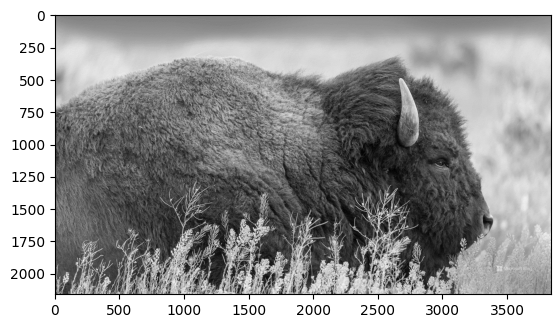

In [6]:
image = Image.open('data/image1.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [7]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

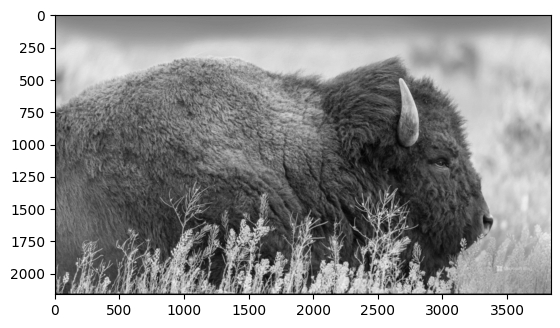

In [9]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [11]:
from PIL import Image

img = Image.open('data/image1.jpg')
img.thumbnail((256,256)) # Resize to half to reduce the size of this notebook.

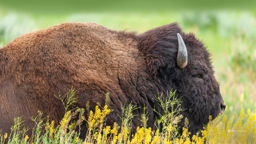

In [12]:
img

In [15]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [16]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [17]:
input = to_tensor(img)
input.shape


torch.Size([1, 144, 256])

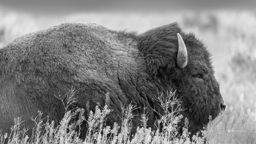

In [18]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [19]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [20]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[-0.0025,  0.0712,  0.0719,  ...,  0.0738,  0.0756,  0.1898],
         [-0.1750, -0.1016, -0.1013,  ..., -0.1126, -0.1133,  0.0274],
         [-0.1796, -0.1070, -0.1043,  ..., -0.1121, -0.1125,  0.0320],
         ...,
         [-0.2064, -0.1276, -0.0622,  ..., -0.1181, -0.1323,  0.0334],
         [-0.1471, -0.0649, -0.0699,  ..., -0.1269, -0.1172,  0.0256],
         [-0.1680, -0.0228,  0.0693,  ...,  0.0018,  0.0156,  0.2217]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [21]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 144, 256])

In [22]:
output = conv(input)
output.shape

torch.Size([1, 1, 144, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [23]:
output.shape

torch.Size([1, 1, 144, 256])

We need to remove the first dimension before converting to a PIL object.

In [24]:
output.data.squeeze(dim=0).shape

torch.Size([1, 144, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

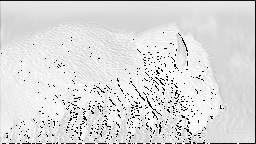

In [25]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

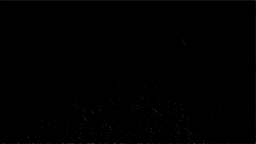

In [26]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [27]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

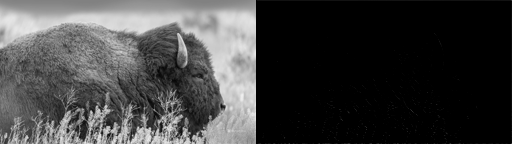

In [28]:
display(input, output)

### Identity

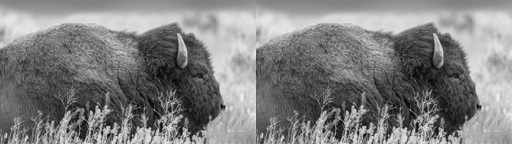

In [29]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


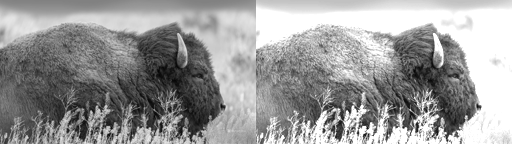

In [30]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


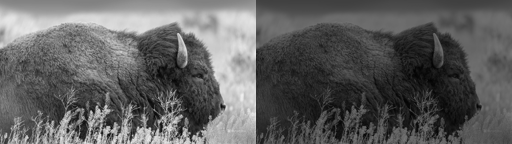

In [31]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


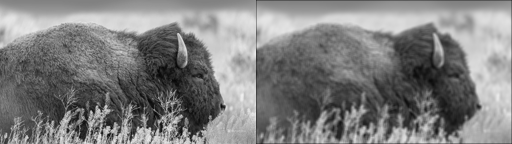

In [32]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


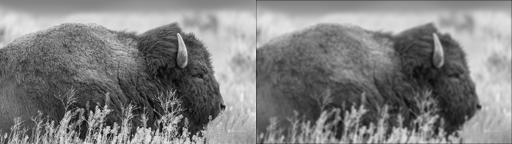

In [33]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


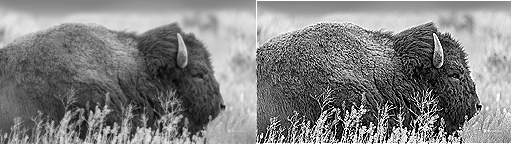

In [34]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


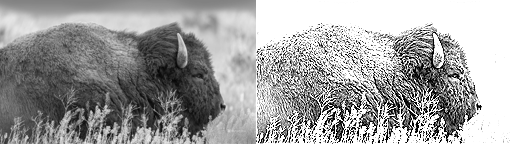

In [35]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


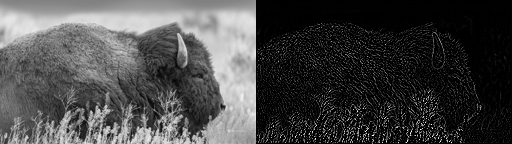

In [36]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

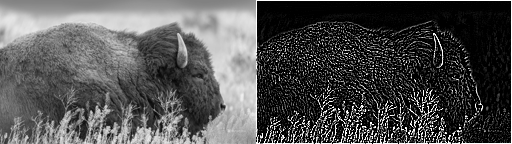

In [37]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

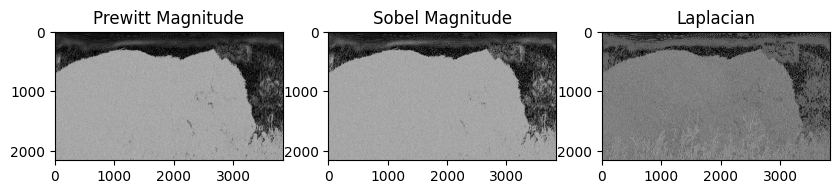

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def convolve(image, kernel):
    return ndimage.convolve(image, kernel, mode='constant', cval=0.0)

def prewitt(image):
    kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

    gradient_x = convolve(image, kernel_x)
    gradient_y = convolve(image, kernel_y)

    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    direction = np.arctan2(gradient_y, gradient_x)

    return magnitude, direction

def sobel(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    gradient_x = convolve(image, kernel_x)
    gradient_y = convolve(image, kernel_y)

    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    direction = np.arctan2(gradient_y, gradient_x)

    return magnitude, direction

def laplacian(image):
    kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

    laplacian_output = convolve(image, kernel)

    return laplacian_output

# Crear una imagen de prueba (puedes reemplazarla con tu propia imagen)
image = Image.open('data/image1.jpg')
image = image.convert('L')  # Convert image to grayscale

# Aplicar los detectores de línea
magnitude_prewitt, _ = prewitt(image)
magnitude_sobel, _ = sobel(image)
laplacian_output = laplacian(image)

# Mostrar las imágenes resultantes
plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.imshow(magnitude_prewitt, cmap='gray')
plt.title('Prewitt Magnitude')

plt.subplot(132)
plt.imshow(magnitude_sobel, cmap='gray')
plt.title('Sobel Magnitude')

plt.subplot(133)
plt.imshow(laplacian_output, cmap='gray')
plt.title('Laplacian')

plt.show()
